## Guideline:

- File to use: **contract_dataset_v20220109.csv**
- Train a **MULTI-CLASS CLASSIFICATION MODEL**. Your final model should be able to take in a test clause (column `provision`) and predict its provision type (column `label`). 
- Perform your own train-test split.
- Choose your own evaluation metrics and explain your choice(s).
- You may refer to, and/or copy code blocks from any public Github repositories, Kaggle kernels or tutorials online. However, please add a comment indicating the source.
- You are free to conduct exploratory data analysis, write unit tests or any other additional steps as you find neccesary.
- The purpose is NOT to train the best-performing model. It is to help us assess your ability to learn and apply NLP modelling techniques.

Distilbert: https://arxiv.org/pdf/1910.01108.pdf 

Notebook Setup

In [1]:
!pip install ktrain
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 66.8 MB/s 
     |████████████████████████████████| 263 kB 73.7 MB/s 
     |████████████████████████████████| 3.8 MB 73.6 MB/s 
     |████████████████████████████████| 1.3 MB 77.2 MB/s 
     |████████████████████████████████| 468 kB 81.7 MB/s 
     |████████████████████████████████| 182 kB 64.3 MB/s 
     |████████████████████████████████| 880 kB 62.3 MB/s 
     |████████████████████████████████| 7.6 MB 73.1 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=18ea3bb3785b87af61fd6b77615419ec95aa2256e3a2de1fb6753c962096e68b
  Stored in directory: /root/.cache/pip/wheels/9c/1c/1b/6df2db85720b8f5c6ea5e3ae37313cfc656f248abf910b7cfd
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=c910c2dd9a622122d2b7dc6

Import Packages

In [2]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.utils import shuffle

import nlpaug.augmenter.word as naw
from tqdm import tqdm


In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/weijie-lim/practice_nlp/main/contract_dataset_v20220109.csv", dtype=str)

Labels:
34549
['governing laws']            12522
['counterparts']               9256
['amendments']                 4795
['terminations']               3748
['waivers']                    3274
['warranties']                  607
['valid issuances']             129
['government regulations']      127
['trade relations']              53
['trading activities']           38
Name: label, dtype: int64


is NULL:
provision         0
label             0
source            0
Contract_Dates    0
Passwords         0
dtype: int64


Check if there are specific word count for each section:
labels include ['waivers', 'governing laws', 'amendments', 'counterparts', 'warranties', 'terminations', 'valid issuances', 'government regulations', 'trade relations', 'trading activities']
['waivers']


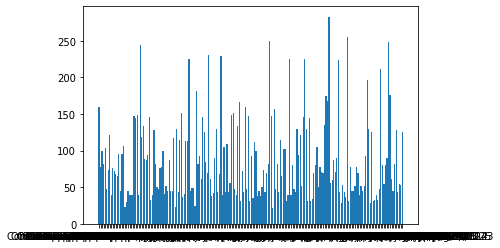

['governing laws']


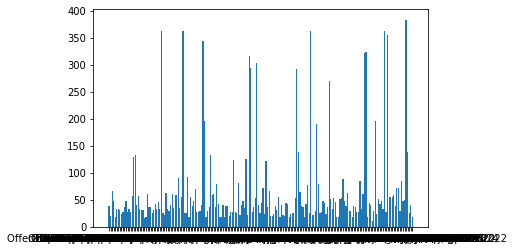

['amendments']


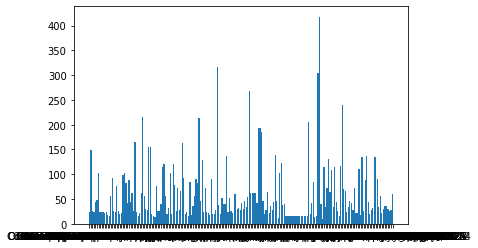

['counterparts']


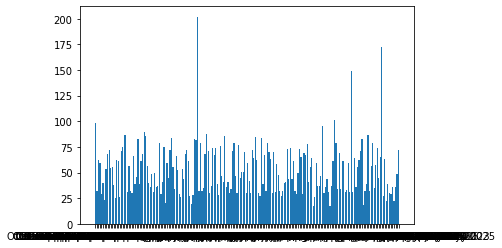

['warranties']


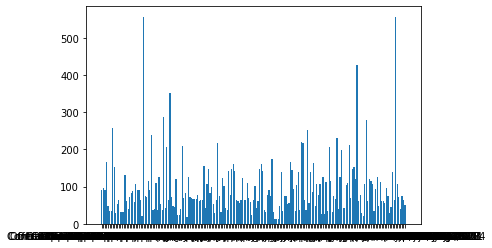

['terminations']


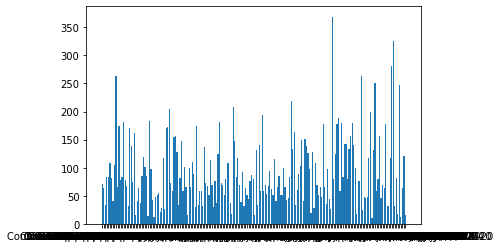

['valid issuances']


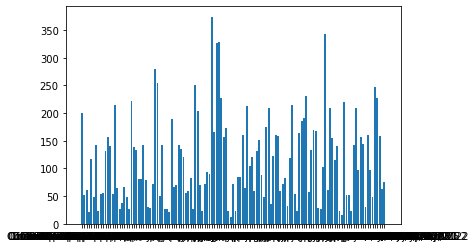

['government regulations']


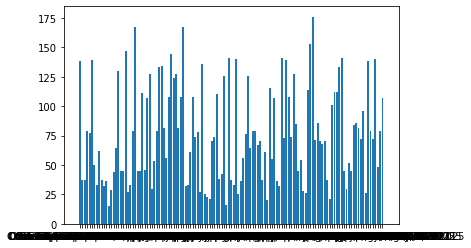

['trade relations']


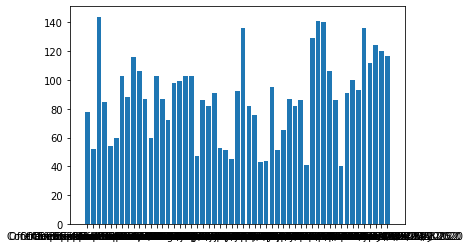

['trading activities']


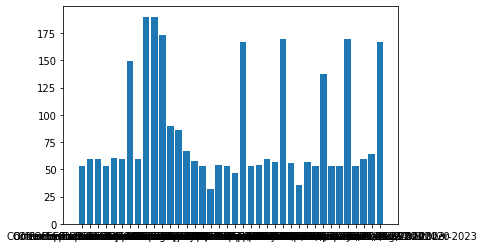

['waivers']


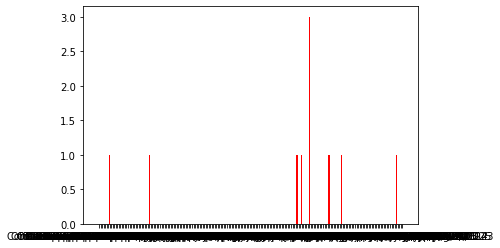

['governing laws']


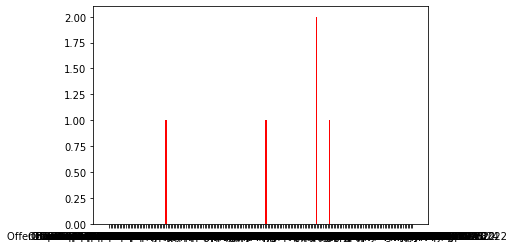

['amendments']


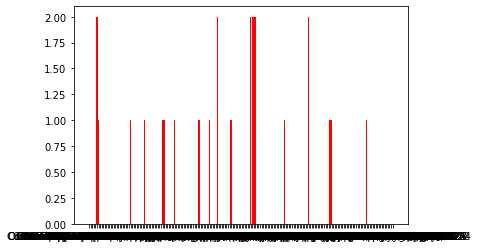

['counterparts']


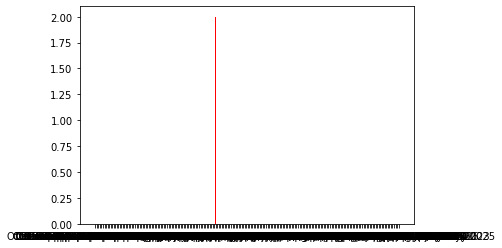

['warranties']


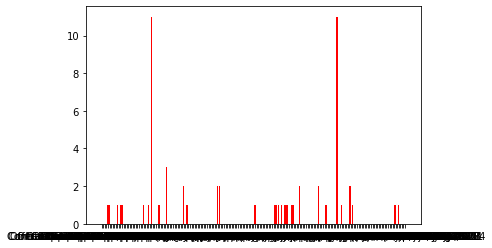

['terminations']


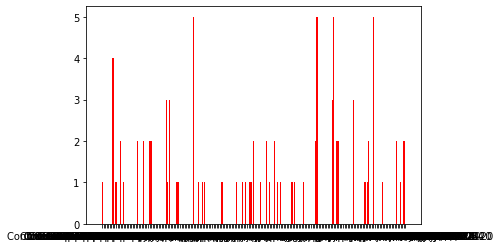

['valid issuances']


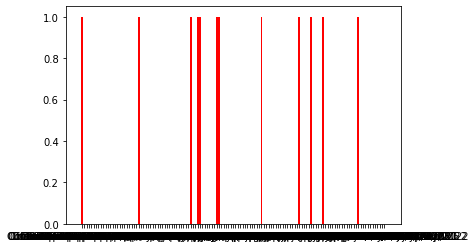

['government regulations']


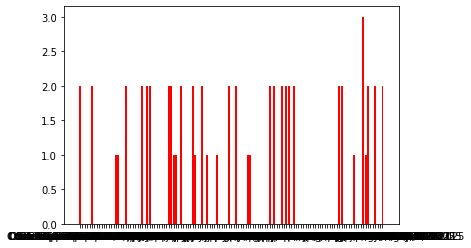

['trade relations']


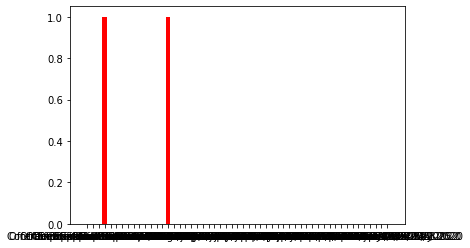

['trading activities']


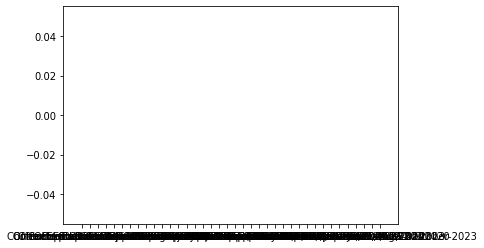

In [5]:
#number of labels
print("Labels:")
print(data['label'].count())
print(data['label'].value_counts())

#check number of null
print('\n')
print("is NULL:")
print(data.isnull().sum())

#number of word count per row
print('\n')
print("Check if there are specific word count for each section:")
data['word_counts'] = data['provision'].apply(lambda x: len(str(x).split()))
labels = data.label.unique()
unique_labels = []
for i in labels:
    unique_labels.append(i.strip("[]\'\'"))
print(f'labels include {list(unique_labels)}')
for i in labels:
    print(i)
    plt.figure()
    d = data[data['label'] == i].head(200)
    x = d['Contract_Dates']
    y = d['word_counts']
    plt.bar(x,y)
    plt.show()

#number of digits in each category
data['numeric_digits'] = data['provision'].apply(lambda x: len([t for t in x.split() if t.isdigit()]))
for i in labels:
    print(i)
    plt.figure()
    d = data[data['label'] == i].head(200)
    x = d['Contract_Dates']
    y = d['numeric_digits']
    plt.bar(x,y, color= 'r')
    plt.show()

Preprocess Model as it is

Points to Note:
A. No One-hot encoding: 
  1. Do not need to one hot encode as categories are not ordinal. i.e. An ordinal data set would be Junior, Senior, Executive, Owner
  2. There are 10 categories, which could lead to high consumption of memory.

B. Balance data or not:
  1. Use oversampling and changing the a certain number of words for its synonyms.
[Stratify is used to ensure there are equal proportions for each category]

C. maxlen is kept at 350 due to the visualisations above and to have faster speed

In [6]:
#strip each row's label from [] ''
for index in data.index:
  val = data.loc[index,'label'].strip("\'\'[]")
  data.loc[index,'label'] = val

data.head()

,provision,label,source,Contract_Dates,Passwords,word_counts,numeric_digits
0,Borrower and any endorsers or guarantors hereo...,waivers,2019/QTR1/000143774919001296/ex_133310.htm,Offer Expiration Date: 6/30/2025,0HT@a@z)jz%,159,0
1,"No failure to exercise, and no delay in exerci...",waivers,2019/QTR1/000149315219002427/ex10-1.htm,Offer Expiration Date: 7/5/2023,v&-TAdyt,77,0
2,Until the Discharge of Senior Lender Claims ha...,waivers,2019/QTR1/000114420419010508/tv513897_ex10-25.htm,Contract Start Date: 1 27 2024,ijwepC|Y:Og,100,0
3,Neither Party shall be deemed to have waived a...,waivers,2019/QTR1/000148881319000009/a1022cobaltagreem...,Offer Expiration Date: 9/2/2023,sYJA +T#t,82,0
4,No waiver of the provisions hereof shall be va...,waivers,2019/QTR1/000114420419011984/tv514470_ex10-15.htm,Contract Start Date: 4 august 2021,9~$z3TJ0N|F!Oep,103,0


{'waivers': 2292, 'governing laws': 8765, 'amendments': 3356, 'counterparts': 6479, 'warranties': 425, 'terminations': 2624, 'valid issuances': 90, 'government regulations': 89, 'trade relations': 37, 'trading activities': 27}

 Before Data Augmentation, shape of data_train
(24184, 2)
governing laws            8765
counterparts              6479
amendments                3356
terminations              2624
waivers                   2292
warranties                 425
valid issuances             90
government regulations      89
trade relations             37
trading activities          27
Name: label, dtype: int64


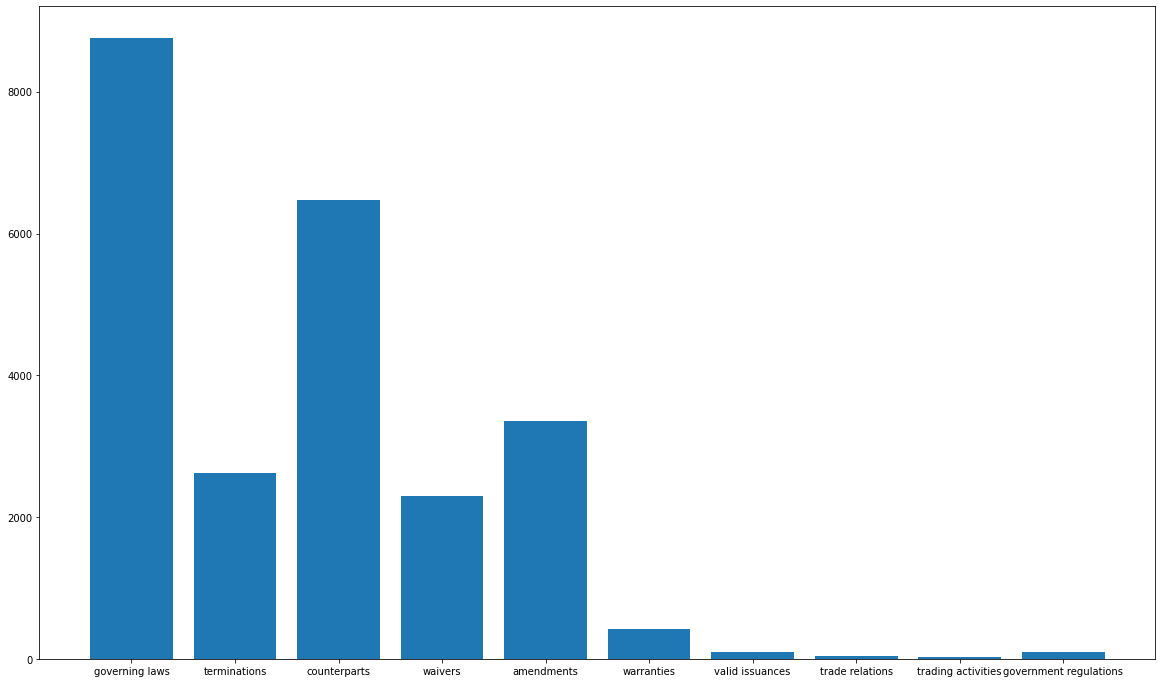

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Done with....label --- waivers --- with currently 2292 records and thereafter each record augmented: 3 times, to reach closer to 8765 times
Next Value count for each label in new df:
waivers    6876
Name: label, dtype: int64




Done with....label --- governing laws --- with currently 8765 records and thereafter each record augmented: 1 times, to reach closer to 8765 times
Next Value count for each label in new df:
governing laws    8765
waivers           6876
Name: label, dtype: int64




Done with....label --- amendments --- with currently 3356 records and thereafter each record augmented: 2 times, to reach closer to 8765 times
Next Value count for each label in new df:
governing laws    8765
waivers           6876
amendments        6712
Name: label, dtype: int64




Done with....label --- counterparts --- with currently 6479 records and thereafter each record augmented: 1 times, to reach closer to 8765 times
Next Value count for each label in new df:
governing laws    8765
waivers  

In [7]:
#split train test
data_train, data_test = train_test_split(data, test_size=0.3, random_state=18, stratify=data['label'])

data_train = data_train.drop(columns=['source', 'Contract_Dates', 'Passwords', 'word_counts', 'numeric_digits'])
data_test = data_test.drop(columns=['source', 'Contract_Dates', 'Passwords', 'word_counts', 'numeric_digits'])

max_v = 0
num_unique_dict = {}
for index, v in enumerate(unique_labels):
  count = data_train[data_train['label']==v]['label'].count()
  num_unique_dict[v] = count
  if count > max_v:
    max_v = count

print(num_unique_dict)

#Oversample minority classes in training data
print("\n", "Before Data Augmentation, shape of data_train")
print(data_train.shape)
print(data_train['label'].value_counts())
y = data_train['label']

# summarize distribution
counter = Counter(y)
# plot the distribution
plt.figure(figsize=(20,12))
plt.bar(counter.keys(), counter.values())
plt.show()

# augment sentence
temp_df = pd.DataFrame({'provision' : [], 'label': [] })
for k, v in num_unique_dict.items():
  samples_to_aug = max_v - v
  times_to_aug = max_v // v

  df = data_train[data_train['label'] == k].reset_index(drop=True)
  temp_df2 = pd.DataFrame({'provision' : [], 'label': [] })
  if samples_to_aug > 1:
    for index in df.index:
      text = df.loc[index, 'provision']
      length = len(text.split())
      syn_aug = naw.SynonymAug(aug_src='wordnet',aug_max=length//10)
      syn_aug_text = syn_aug.augment(text,n=times_to_aug)
      label_list = [k for i in range(times_to_aug)]
      df2 = pd.DataFrame({'provision' : syn_aug_text, 'label': label_list })
      temp_df2 = temp_df2.append(df2,ignore_index=True)
  else:
    temp_df2 = df
  temp_df = temp_df.append(temp_df2,ignore_index=True)
  print("Done with....label ---", k, "--- with currently", v,"records and thereafter each record augmented:", times_to_aug, "times, to reach closer to", max_v, "times")
  print("Next Value count for each label in new df:")
  print(temp_df['label'].value_counts())
  print("\n")
  print("\n")

In [8]:
temp_df = shuffle(temp_df)
data_train = temp_df

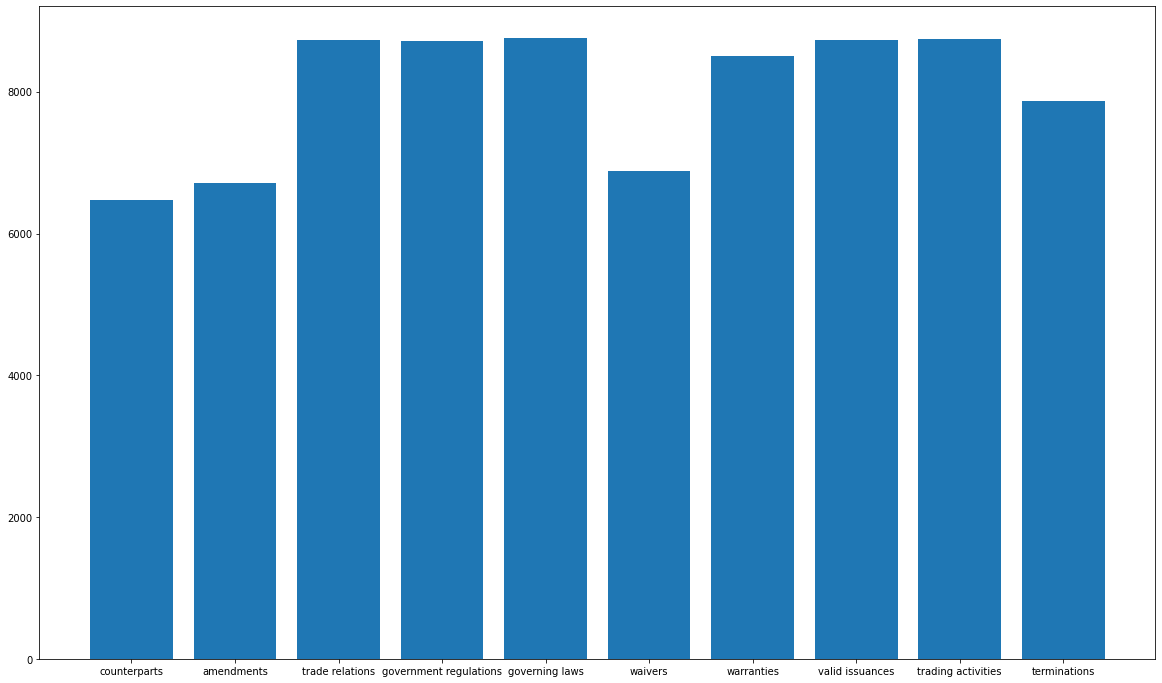


 After Data Augmentation, shape of data_train
(80136, 2)


In [9]:
y = data_train['label']
# summarize new distribution
counter = Counter(y)
# plot the distribution
plt.figure(figsize=(20,12))
plt.bar(counter.keys(), counter.values())
plt.show()

print("\n", "After Data Augmentation, shape of data_train")
print(data_train.shape)

In [10]:
data_train.head()

,provision,label
26136,This Agreement may be executed in counterparts...,counterparts
18365,"This Amendment, duly carry out and delivered b...",amendments
63374,There exists no genuine or threatened terminat...,trade relations
59993,No Credit Party is an “ investment company ” r...,government regulations
10481,This Agreement shall be interpreted and enforc...,governing laws


In [11]:
from ktrain import text
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [17]:
(train, val, preproc) = text.texts_from_df(train_df=data_train, 
                                           text_column="provision", 
                                           label_columns="label", 
                                           val_df=data_test,
                                           maxlen=400,
                                           preprocess_mode='distilbert')

['amendments', 'counterparts', 'governing laws', 'government regulations', 'terminations', 'trade relations', 'trading activities', 'valid issuances', 'waivers', 'warranties']
       amendments  counterparts  governing laws  government regulations  \
26136         0.0           1.0             0.0                     0.0   
18365         1.0           0.0             0.0                     0.0   
63374         0.0           0.0             0.0                     0.0   
59993         0.0           0.0             0.0                     1.0   
10481         0.0           0.0             1.0                     0.0   

       terminations  trade relations  trading activities  valid issuances  \
26136           0.0              0.0                 0.0              0.0   
18365           0.0              0.0                 0.0              0.0   
63374           0.0              1.0                 0.0              0.0   
59993           0.0              0.0                 0.0         

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 76
	95percentile : 223
	99percentile : 371


In [18]:
data_train.head()

,provision,label
26136,This Agreement may be executed in counterparts...,counterparts
18365,"This Amendment, duly carry out and delivered b...",amendments
63374,There exists no genuine or threatened terminat...,trade relations
59993,No Credit Party is an “ investment company ” r...,government regulations
10481,This Agreement shall be interpreted and enforc...,governing laws


In [19]:
model = text.text_classifier(name='distilbert',
                             train_data=train,
                             preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


Check different Variables:
1. Keep epoch at 3 due to long training time, if training accuracy > validation accuracy or validation loss starting going up, shows overfitting, bring down the epochs
https://stackoverflow.com/questions/51344839/what-is-the-difference-between-the-terms-accuracy-and-validation-accuracy


2. Change batch_size to 4, 8, 12, 16
3. Find the optimal learning rate by using learning rate plot and using that learning rate to autofit

https://medium.com/analytics-vidhya/finetuning-bert-using-ktrain-for-disaster-tweets-classification-18f64a50910b

Test results show lower learning rate and smaller batch size is better:

A. https://web.stanford.edu/class/cs224n/reports/default_116973469.pdf  -- smaller learning rate is better and has a higher impact than batch size, thus we will look at the batch_size with the lowest learning rate

B. https://wandb.ai/jack-morris/david-vs-goliath/reports/Does-Model-Size-Matter-A-Comparison-of-BERT-and-DistilBERT--VmlldzoxMDUxNzU

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
20034/20034 [==============================] - 92s 3ms/step - loss: 2.2775 - accuracy: 0.2835


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


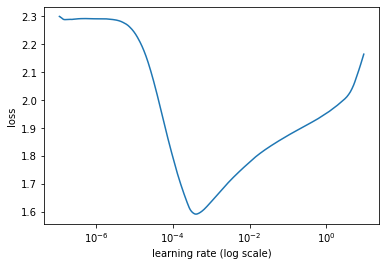

In [20]:
learner1 = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size=4)

learner1.lr_find()
learner1.lr_plot()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
10017/10017 [==============================] - 109s 10ms/step - loss: 919.3231 - accuracy: 0.2994


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


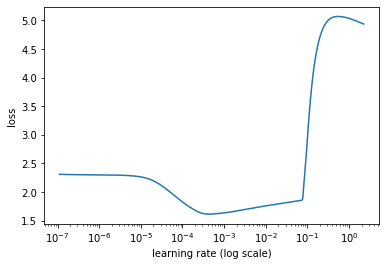

In [21]:
learner2 = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size=8)

learner2.lr_find()
learner2.lr_plot()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
6678/6678 [==============================] - 151s 20ms/step - loss: 2.0647 - accuracy: 0.3040


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


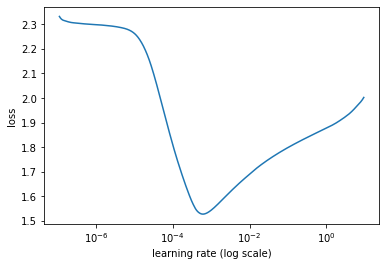

In [22]:
learner3 = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size=12)
learner3.lr_find()
learner3.lr_plot()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
5008/5008 [==============================] - 183s 34ms/step - loss: 3.7510 - accuracy: 0.3042


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


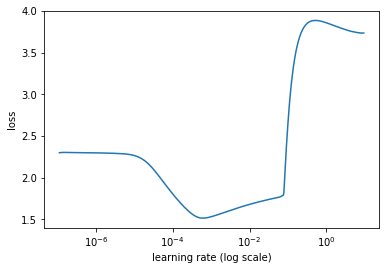

In [23]:
learner4 = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size= 16)
learner4.lr_find()
learner4.lr_plot()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
2504/2504 [==============================] - 317s 121ms/step - loss: 2.0508 - accuracy: 0.3209


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


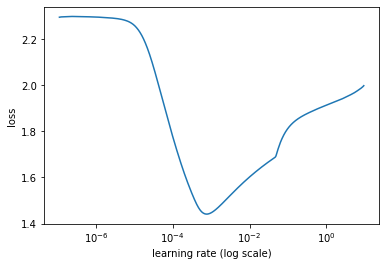

In [24]:
learner5 = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size= 32)
learner5.lr_find()
learner5.lr_plot()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
1252/1252 [==============================] - 391s 301ms/step - loss: 1.6265 - accuracy: 0.4374
Epoch 2/1024
1252/1252 [==============================] - 43s 34ms/step - loss: 34.6802 - accuracy: 0.0998


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


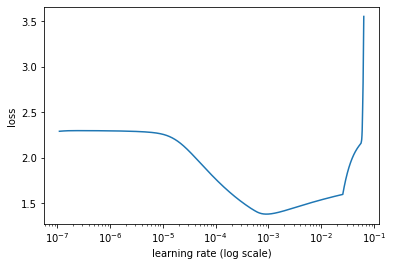

In [25]:
learner6 = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size= 64)
learner6.lr_find()
learner6.lr_plot()

In [26]:
#seems like the best model with highest accuracy are larger batch_sizes
#however due to the long training time: we will choose batch_size 16 with learning rate of 7e-4
learner6.autofit(1e-3)
learner6.validate(class_names=unique_labels) 


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
1253/1253 [==============================] - 421s 318ms/step - loss: 1.7803 - accuracy: 0.3253 - val_loss: 2.3547 - val_accuracy: 0.3625
Epoch 2/1024
1253/1253 [==============================] - 412s 317ms/step - loss: 2.2969 - accuracy: 0.1076 - val_loss: 2.3443 - val_accuracy: 0.3625
Epoch 3/1024
 166/1253 [==>...........................] - ETA: 5:27 - loss: 2.2964 - accuracy: 0.1098

KeyboardInterrupt: ignored

In [28]:
#the above attempt looks like it will take a rather long time for the training to 
#achieve a high accuracy, hence we will 
#attempt to do a one_cycle_fit instead with 1 and 2 epochs to see the results with a standard
#batch size of 16 and smaller max learning rate of 1e-5, based on the learning rate 
#finder
learner7 = ktrain.get_learner(model=model,
                             train_data=train,
                             val_data=val,
                             batch_size= 16)
learner7.fit_onecycle(lr = 5e-4, epochs=1)
learner7.validate(class_names=unique_labels)



begin training using onecycle policy with max lr of 0.0005...
324/324 [==============================] - 21s 61ms/step
                        precision    recall  f1-score   support

               waivers       0.00      0.00      0.00      1439
        governing laws       0.00      0.00      0.00      2777
            amendments       0.98      0.25      0.40      3757
          counterparts       0.01      0.11      0.03        38
            warranties       0.19      0.36      0.25      1124
          terminations       0.01      0.81      0.03        16
       valid issuances       0.00      0.82      0.00        11
government regulations       0.02      0.64      0.03        39
       trade relations       0.00      0.00      0.00       982
    trading activities       0.03      0.07      0.04       182

              accuracy                           0.13     10365
             macro avg       0.12      0.30      0.08     10365
          weighted avg       0.38      0.13  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,    0,    0,    0,  538,    1,  738,   32,    0,  130],
       [   0,    0,    0,    0,  626,    0, 2101,    7,    0,   43],
       [   0,    0,  931,  271,   42,  891,   15, 1505,    0,  102],
       [   0,    0,    9,    4,    1,   13,    0,   11,    0,    0],
       [   0,    0,    2,    1,  403,    0,  654,   13,    0,   51],
       [   0,    0,    2,    1,    0,   13,    0,    0,    0,    0],
       [   0,    0,    0,    0,    2,    0,    9,    0,    0,    0],
       [   0,    0,    2,    0,    4,    0,    2,   25,    0,    6],
       [   0,    0,    1,    0,  423,    2,  426,   20,    0,  110],
       [   0,    0,    0,    0,   79,    0,   81,   10,    0,   12]])

In [30]:
#training accuracy above is decreasing as the epoch progresses, showing that my learning
#rate is actually too high, hence I will attempt to lower it by one order of magnitude
#check if it improves
learner7.fit_onecycle(lr = 5e-5, epochs=2)
learner7.validate(class_names=unique_labels)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/2
5009/5009 [==============================] - 498s 96ms/step - loss: 1.4068 - accuracy: 0.4326 - val_loss: 1.2445 - val_accuracy: 0.4352
Epoch 2/2
324/324 [==============================] - 20s 61ms/step
                        precision    recall  f1-score   support

               waivers       0.55      0.38      0.45      1439
        governing laws       0.90      0.97      0.93      2777
            amendments       0.99      0.79      0.88      3757
          counterparts       0.06      0.76      0.12        38
            warranties       0.37      0.59      0.45      1124
          terminations       0.73      1.00      0.84        16
       valid issuances       0.91      0.91      0.91        11
government regulations       0.09      0.97      0.17        39
       trade relations       0.63      0.02      0.05       982
    trading activities       0.20      0.71      0.31       182

              accu

array([[ 544,  249,    6,    0,  522,    1,    0,   18,    3,   96],
       [  69, 2687,    0,    0,   18,    0,    0,    0,    2,    1],
       [   1,    0, 2959,  422,    6,    1,    0,  326,    3,   39],
       [   0,    0,    8,   29,    0,    1,    0,    0,    0,    0],
       [ 314,   46,    2,    1,  667,    3,    1,    9,    4,   77],
       [   0,    0,    0,    0,    0,   16,    0,    0,    0,    0],
       [   0,    1,    0,    0,    0,    0,   10,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0,    0,   38,    0,    0],
       [  61,   10,    4,    0,  565,    0,    0,   12,   24,  306],
       [   1,    1,    5,    0,   36,    0,    0,    8,    2,  129]])

In [31]:
#run it for 8 epochs (quadruple of the previous) to see if it improves the model
learner7.fit_onecycle(lr = 5e-5, epochs=8)
learner7.validate(class_names=unique_labels)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/8
5009/5009 [==============================] - 494s 96ms/step - loss: 0.6868 - accuracy: 0.7389 - val_loss: 0.5827 - val_accuracy: 0.7717
Epoch 2/8
5009/5009 [==============================] - 495s 96ms/step - loss: 0.5256 - accuracy: 0.8107 - val_loss: 0.4463 - val_accuracy: 0.8589
Epoch 3/8
5009/5009 [==============================] - 495s 96ms/step - loss: 0.3602 - accuracy: 0.8890 - val_loss: 0.3258 - val_accuracy: 0.9150
Epoch 4/8
5009/5009 [==============================] - 494s 96ms/step - loss: 0.2434 - accuracy: 0.9362 - val_loss: 0.2262 - val_accuracy: 0.9475
Epoch 5/8
4883/5009 [============================>.] - ETA: 11s - loss: 0.2164 - accuracy: 0.9457

KeyboardInterrupt: ignored

In [33]:
learner7.fit_onecycle(lr = 5e-6, epochs=1)
learner7.validate(class_names=unique_labels)



begin training using onecycle policy with max lr of 5e-06...
324/324 [==============================] - 20s 61ms/step
                        precision    recall  f1-score   support

               waivers       0.91      0.77      0.83      1439
        governing laws       0.98      0.98      0.98      2777
            amendments       1.00      0.96      0.98      3757
          counterparts       0.84      1.00      0.92        38
            warranties       0.79      0.92      0.85      1124
          terminations       0.89      1.00      0.94        16
       valid issuances       1.00      0.82      0.90        11
government regulations       0.37      0.97      0.53        39
       trade relations       0.88      0.93      0.90       982
    trading activities       0.71      0.92      0.80       182

              accuracy                           0.93     10365
             macro avg       0.84      0.93      0.86     10365
          weighted avg       0.94      0.93   

array([[1103,   49,    5,    0,  210,    2,    0,    3,   59,    8],
       [  46, 2724,    0,    0,    5,    0,    0,    0,    1,    1],
       [  12,    1, 3614,    5,    6,    0,    0,   61,   15,   43],
       [   0,    0,    0,   38,    0,    0,    0,    0,    0,    0],
       [  47,    0,    2,    1, 1030,    0,    0,    0,   40,    4],
       [   0,    0,    0,    0,    0,   16,    0,    0,    0,    0],
       [   0,    2,    0,    0,    0,    0,    9,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,   38,    1,    0],
       [   6,    0,    1,    1,   48,    0,    0,    0,  913,   13],
       [   0,    0,    1,    0,    2,    0,    0,    2,    9,  168]])

Save Model

In [34]:
predictor = ktrain.get_predictor(learner7.model, preproc)

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
predictor.save('/content/drive/My Drive/distilbert')